In [ ]:
!pip3 install torch torchvision
!pip3 install matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 118.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 87.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 11.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitl

# Import the file annotations.json

In [ ]:
import os
import json
import requests
import random
import yaml
from tqdm import tqdm
from PIL import Image

# === Load TACO annotations ===
ANNOTATIONS_FILE = "/content/annotations.json"
OUTPUT_DIR = "./TACO_YOLO"  # save path
TRAIN_RATIO = 1450  # Number of images for training
VAL_RATIO = 50      # Number of images for validation

# === Create output directories ===
os.makedirs(f"{OUTPUT_DIR}/train/images", exist_ok=True)
os.makedirs(f"{OUTPUT_DIR}/train/labels", exist_ok=True)
os.makedirs(f"{OUTPUT_DIR}/val/images", exist_ok=True)
os.makedirs(f"{OUTPUT_DIR}/val/labels", exist_ok=True)

# === Load JSON data ===
with open(ANNOTATIONS_FILE, "r") as f:
    taco_data = json.load(f)

images = taco_data["images"]
annotations = taco_data["annotations"]
categories = taco_data["categories"]

# === Map category IDs to names ===
category_id_to_name = {cat["id"]: cat["name"] for cat in categories}
category_id_to_index = {cat["id"]: i for i, cat in enumerate(categories)}

# === Prepare Image List ===
random.shuffle(images)  # Shuffle images before splitting
train_images = images[:TRAIN_RATIO]
val_images = images[TRAIN_RATIO:TRAIN_RATIO + VAL_RATIO]

# === Function to download images ===
def download_image(image_info, save_path):
    url = image_info.get("flickr_640_url") or image_info.get("flickr_url")
    if not url:
        return False

    # Ensure parent directory exists
    os.makedirs(os.path.dirname(save_path), exist_ok=True)

    try:
        response = requests.get(url, stream=True, timeout=10)
        if response.status_code == 200:
            with open(save_path, "wb") as f:
                for chunk in response.iter_content(1024):
                    f.write(chunk)
            return True
    except requests.RequestException:
        return False
    return False

# === Process and save images & annotations in YOLO format ===
def process_dataset(image_list, split):
    for image in tqdm(image_list, desc=f"Processing {split} images"):
        image_id = image["id"]
        file_name = image["file_name"]
        width, height = image["width"], image["height"]

        # Ensure subdirectories exist
        image_save_path = f"{OUTPUT_DIR}/{split}/images/{file_name}"
        os.makedirs(os.path.dirname(image_save_path), exist_ok=True)

        # Download and save image
        if not download_image(image, image_save_path):
            print(f"Skipping {file_name} (Failed to download)")
            continue

        # Filter annotations for this image
        image_annotations = [ann for ann in annotations if ann["image_id"] == image_id]
        if not image_annotations:
            continue  # Skip images with no annotations

        # Convert annotations to YOLO format
        yolo_annotations = []
        for ann in image_annotations:
            bbox = ann["bbox"]
            category_id = ann["category_id"]

            # Convert bbox [x, y, width, height] -> [x_center, y_center, width, height] (normalized)
            x, y, w, h = bbox
            x_center = (x + w / 2) / width
            y_center = (y + h / 2) / height
            w /= width
            h /= height

            yolo_annotations.append(f"{category_id_to_index[category_id]} {x_center:.6f} {y_center:.6f} {w:.6f} {h:.6f}")

        # Ensure label directory exists
        label_save_path = f"{OUTPUT_DIR}/{split}/labels/{file_name.replace('.jpg', '.txt').replace('.png', '.txt')}"
        os.makedirs(os.path.dirname(label_save_path), exist_ok=True)

        # Save annotation file
        with open(label_save_path, "w") as f:
            f.write("\n".join(yolo_annotations))

# === Process train and validation datasets ===
process_dataset(train_images, "train")
process_dataset(val_images, "val")

# === Create dataset.yaml for YOLOv11 training ===
dataset_yaml = {
    "train": f"/content/TACO_YOLO/train/images",
    "val": f"/content/TACO_YOLO/train/images",
    "nc": len(category_id_to_index),
    "names": [category_id_to_name[i] for i in sorted(category_id_to_index.keys())]
}

# Save YAML file
yaml_path = f"{OUTPUT_DIR}/taco_yolo.yaml"
with open(yaml_path, "w") as f:
    yaml.dump(dataset_yaml, f, default_flow_style=False)

print(f"✅ Dataset preparation complete! YOLO dataset saved in {OUTPUT_DIR}")
print(f"✅ Dataset configuration saved at: {yaml_path}")


Processing val images: 100%|██████████| 50/50 [00:31<00:00,  1.59it/s]

✅ Dataset preparation complete! YOLO dataset saved in ./TACO_YOLO
✅ Dataset configuration saved at: ./TACO_YOLO/taco_yolo.yaml


In [ ]:
# Import necessary libraries
import os
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.transforms import functional as F
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from time import time
from collections import defaultdict
import yaml

# ----------------------------
#   1) DATASET DEFINITION
# ----------------------------

train_path = "/content/TACO_YOLO/train"
val_path   = "/content/TACO_YOLO/val"
num_epochs = 100

# Load the YAML file
with open('/content/TACO_YOLO/taco_yolo.yaml', 'r') as file:
    data = yaml.safe_load(file)

# Extract the class names from the 'names' key
classes = data['names']

# Display the extracted class names
# print(classes)

num_classes = len(classes) + 1  # +1 for background (class 0)

class CustomDataset(Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms

        # Recursively collect all image and label file paths
        self.imgs = []
        self.labels = []

        image_root = os.path.join(root, "images")
        label_root = os.path.join(root, "labels")

        # Dictionary mapping filenames to paths for alignment
        img_dict = {}
        lbl_dict = {}

        # Collect images
        for batch_folder in os.listdir(image_root):
            batch_path = os.path.join(image_root, batch_folder)
            if os.path.isdir(batch_path):
                for f in os.listdir(batch_path):
                    if f.lower().endswith(('.jpg', '.jpeg', '.png')):
                        img_dict[f.split('.')[0]] = os.path.join(batch_folder, f)

        # Collect labels
        for batch_folder in os.listdir(label_root):
            batch_path = os.path.join(label_root, batch_folder)
            if os.path.isdir(batch_path):
                for f in os.listdir(batch_path):
                    if f.lower().endswith('.txt'):
                        lbl_dict[f.split('.')[0]] = os.path.join(batch_folder, f)

        # Keep only matched pairs (common filenames)
        common_keys = set(img_dict.keys()).intersection(set(lbl_dict.keys()))
        self.imgs = [img_dict[key] for key in common_keys]
        self.labels = [lbl_dict[key] for key in common_keys]

        self.imgs.sort()
        self.labels.sort()

        print(f"Total matched images: {len(self.imgs)}")
        print(f"Total matched labels: {len(self.labels)}")

        if len(self.imgs) == 0 or len(self.labels) == 0:
            raise ValueError("No matched images or labels found — check folder structure and filenames.")

    def __getitem__(self, idx):
        img_path = os.path.join(self.root, "images", self.imgs[idx])
        label_path = os.path.join(self.root, "labels", self.labels[idx])

        # Read image
        img_array = plt.imread(img_path)
        if len(img_array.shape) == 2:
            img_array = np.stack([img_array] * 3, axis=-1)
        elif img_array.shape[2] == 4:
            img_array = img_array[..., :3]
        img = F.to_tensor(img_array)

        # Parse label file
        boxes, labels = [], []
        with open(label_path) as f:
            for line in f:
                data = line.strip().split()
                labels.append(int(data[0]))
                x_center, y_center, width, height = map(float, data[1:])
                x_min = (x_center - width / 2) * img.shape[2]
                y_min = (y_center - height / 2) * img.shape[1]
                x_max = (x_center + width / 2) * img.shape[2]
                y_max = (y_center + height / 2) * img.shape[1]
                boxes.append([x_min, y_min, x_max, y_max])

        if len(boxes) == 0:
            boxes = [[0, 0, 1, 1]]
            labels = [0]

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        target = {"boxes": boxes, "labels": labels}

        if self.transforms:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)




train_dataset = CustomDataset(train_path)
val_dataset   = CustomDataset(val_path)

def collate_fn(batch):
    return tuple(zip(*batch))

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True,  collate_fn=collate_fn)
val_loader   = DataLoader(val_dataset,   batch_size=4, shuffle=False, collate_fn=collate_fn)


# ----------------------------
#   2) MODEL DEFINITION
# ----------------------------

def get_model(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model


# ----------------------------
#   3) mAP EVALUATION
# ----------------------------

def compute_iou(boxA, boxB):
    """
    Compute IoU between a single boxA and multiple boxB boxes:
    boxA: shape (4,)  -> [x1, y1, x2, y2]
    boxB: shape (N,4) -> [x1, y1, x2, y2]
    """
    xA = np.maximum(boxA[0], boxB[:, 0])
    yA = np.maximum(boxA[1], boxB[:, 1])
    xB = np.minimum(boxA[2], boxB[:, 2])
    yB = np.minimum(boxA[3], boxB[:, 3])

    interArea = np.maximum(0, xB - xA) * np.maximum(0, yB - yA)
    boxAArea  = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea  = (boxB[:, 2] - boxB[:, 0]) * (boxB[:, 3] - boxB[:, 1])
    iou = interArea / (boxAArea + boxBArea - interArea + 1e-6)
    return iou

def evaluate_map(model, data_loader, device, iou_thresholds=None, score_threshold=0.0):
    """
    Evaluate mean Average Precision for IoU in [0.5:0.95] with step=0.05 (COCO style),
    plus the specific case IoU=0.50 (Pascal VOC style).
    - model: your trained model
    - data_loader: validation loader
    - device: 'cuda' or 'cpu'
    - iou_thresholds: list/array of IoU thresholds to test. If None, defaults to np.arange(0.5, 1.0, 0.05).
    - score_threshold: filter out predictions with a confidence below this threshold
    """
    if iou_thresholds is None:
        iou_thresholds = np.arange(0.5, 1.0, 0.05)

    model.eval()

    # We will store all predictions and GTs for each class
    # predictions[class_id] = list of (score, is_tp_or_fp)
    # total_gts[class_id] = total number of ground-truth boxes for that class
    predictions = defaultdict(list)  # {class_id: [(score, TP/FP), ...], ...}
    total_gts   = defaultdict(int)   # {class_id: count_of_gt}

    with torch.no_grad():
        for images, targets in data_loader:
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            outputs = model(images)

            for out, tgt in zip(outputs, targets):
                # Convert to CPU numpy
                pred_boxes  = out["boxes"].cpu().numpy()
                pred_labels = out["labels"].cpu().numpy()
                pred_scores = out["scores"].cpu().numpy()

                gt_boxes  = tgt["boxes"].cpu().numpy()
                gt_labels = tgt["labels"].cpu().numpy()

                # Count how many GT boxes per class
                for gt_label in gt_labels:
                    total_gts[int(gt_label)] += 1

                # Filter out predictions below score_threshold
                keep = pred_scores >= score_threshold
                pred_boxes  = pred_boxes[keep]
                pred_labels = pred_labels[keep]
                pred_scores = pred_scores[keep]

                # For matching, we do a standard procedure:
                # 1) Sort predictions by descending score
                # 2) For each prediction, find best IoU with a GT of the same class that is not yet matched
                #    Mark it as TP if IoU >= threshold (handled later), otherwise FP.
                # We'll store all in a structure for now, then loop over IoU thresholds.
                # => We store them in predictions dict with an indicator that says "pending GT match" + the box.

                # We'll store the box for each pred, so we can do the matching separately for each IoU threshold.
                # Let's keep them in a single pass container:
                # predictions[class_id] = [(score, box, matched?), ...], matched? will be assigned after.
                indices_sorted = np.argsort(-pred_scores)  # descending
                pred_boxes  = pred_boxes[indices_sorted]
                pred_labels = pred_labels[indices_sorted]
                pred_scores = pred_scores[indices_sorted]

                # We keep track of GT boxes used per class, then match them after.
                # For mAP, we do the matching per IoU threshold, so let's store data in a workable structure:
                for box, label, score in zip(pred_boxes, pred_labels, pred_scores):
                    # ignore background label = 0
                    if label == 0:
                        continue
                    predictions[int(label)].append((score, box, gt_boxes[gt_labels == label]))

    # Now we compute the AP for each class, for each IoU threshold, then average.
    # For each IoU threshold, we do a standard "predictions sorted by score" approach:
    AP_per_class = {th: np.zeros(num_classes) for th in iou_thresholds}
    valid_classes = [c for c in range(1, num_classes)]  # exclude background=0

    for class_id in valid_classes:
        # Gather all predictions for this class across the dataset
        # each entry: (score, box, array_of_gt_boxes_for_that_class_in_that_image)
        class_preds = predictions[class_id]
        if len(class_preds) == 0:
            # no predictions for that class
            for th in iou_thresholds:
                AP_per_class[th][class_id] = 0.0
            continue

        # Sort by descending confidence
        class_preds.sort(key=lambda x: x[0], reverse=True)

        # loop over each IoU threshold and do matching:
        for th in iou_thresholds:
            TP = np.zeros(len(class_preds), dtype=np.float32)
            FP = np.zeros(len(class_preds), dtype=np.float32)

            # Keep track of which GT boxes were matched (per image).
            # stored all GT boxes for each prediction. We need a robust way to mark them matched or not.
            # Since we didn't keep an ID for each GT box individually, we can do a simpler approach:
            #   For each prediction, we see if there's any GT box with IoU >= th. If yes, it's a potential match.
            #   But we must ensure we match each GT box at most once, so we keep track of matched boxes with a set.

            # If a prediction matches a box (IoU >= th), we mark it matched and break.
            # We'll do that now:
            matched_flags_list = []
            for idx_pred, (score, pred_box, gt_boxes_same_image) in enumerate(class_preds):
                if len(gt_boxes_same_image) == 0:
                    # No GT boxes for that label in that image => it's a false positive
                    FP[idx_pred] = 1
                    matched_flags_list.append([])  # no GT to match with
                else:
                    # create a matched array if not existing yet
                    matched_array = np.zeros(len(gt_boxes_same_image), dtype=bool)
                    # find best IoU
                    ious = compute_iou(pred_box, gt_boxes_same_image)
                    max_iou_idx = np.argmax(ious)
                    max_iou_val = ious[max_iou_idx]
                    if max_iou_val >= th and not matched_array[max_iou_idx]:
                        # It's a true positive
                        TP[idx_pred] = 1
                        matched_array[max_iou_idx] = True
                    else:
                        # It's a false positive
                        FP[idx_pred] = 1
                    matched_flags_list.append(matched_array)

            # Now we compute precision & recall for this class at IoU=th by
            # stepping through the sorted detections:
            acc_TP = np.cumsum(TP)
            acc_FP = np.cumsum(FP)
            recalls    = acc_TP / (total_gts[class_id] + 1e-6)
            precisions = acc_TP / (acc_TP + acc_FP + 1e-6)

            # AP is the area under precision-recall curve
            # We can do the 11-point interpolation or the more common "continuous" interpolation
            # Insert (r=0, p=1) at the start
            recalls    = np.concatenate(([0.0], recalls))
            precisions = np.concatenate(([1.0], precisions))
            for i in range(len(precisions) - 1, 0, -1):
                precisions[i-1] = max(precisions[i-1], precisions[i])

            # Compute area under curve
            indices = np.where(recalls[1:] != recalls[:-1])[0]
            ap = 0.0
            for i in indices:
                ap += (recalls[i+1] - recalls[i]) * precisions[i+1]
            AP_per_class[th][class_id] = ap

    # Now average AP across classes for each threshold:
    mAPs = []
    for th in iou_thresholds:
        # exclude background=0 from the average
        valid_APs = [AP_per_class[th][cid] for cid in valid_classes]
        mAPs.append(np.mean(valid_APs))

    # mAP@50 is the first threshold (assuming iou_thresholds[0] = 0.5)
    map_50 = mAPs[0]
    # Average across all thresholds
    map_50_95 = np.mean(mAPs)

    return map_50, map_50_95


# ----------------------------
#   4) TRAINING LOOP
# ----------------------------

def train_model(model, train_loader, val_loader, device, num_epochs):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

    metrics_df = pd.DataFrame(columns=[
        "epoch", "time",
        "train/box_loss", "train/cls_loss", "train/dfl_loss",
        "metrics/precision(B)", "metrics/recall(B)",
        "val/box_loss", "val/cls_loss", "val/dfl_loss",
        "metrics/mAP@50", "metrics/mAP@50-95",
        "lr/pg0", "lr/pg1", "lr/pg2"
    ])

    for epoch in range(num_epochs):
        start_time = time()
        model.train()

        # ----------------------
        # Training step
        # ----------------------
        train_box_loss, train_cls_loss, train_dfl_loss = 0.0, 0.0, 0.0
        for images, targets in train_loader:
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            loss_dict = model(images, targets)
            loss_box = loss_dict.get("loss_box_reg", torch.tensor(0.0))
            loss_cls = loss_dict.get("loss_classifier", torch.tensor(0.0))
            loss_sum = sum(loss_dict.values())

            train_box_loss += loss_box.item()
            train_cls_loss += loss_cls.item()
            train_dfl_loss += loss_sum.item()

            optimizer.zero_grad()
            loss_sum.backward()
            optimizer.step()

        train_box_loss /= len(train_loader)
        train_cls_loss /= len(train_loader)
        train_dfl_loss /= len(train_loader)

        # ----------------------
        # Validation step
        # ----------------------
        model.eval()
        val_box_loss, val_cls_loss, val_dfl_loss = 0.0, 0.0, 0.0
        precision, recall = 0.0, 0.0

        with torch.no_grad():
            for images, targets in val_loader:
                images = [img.to(device) for img in images]
                targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

                # Switch briefly to train mode to get val losses
                model.train()
                loss_dict_val = model(images, targets)
                val_box_loss  += loss_dict_val.get("loss_box_reg", torch.tensor(0.0)).item()
                val_cls_loss  += loss_dict_val.get("loss_classifier", torch.tensor(0.0)).item()
                val_dfl_loss  += sum(loss_dict_val.values()).item()
                model.eval()

                # Quick precision/recall at IoU=0.5 (like before)
                outputs = model(images)
                batch_tp, batch_fp, batch_fn = 0, 0, 0
                iou_threshold = 0.5
                for i, out in enumerate(outputs):
                    pred_boxes  = out["boxes"].cpu().numpy()
                    pred_labels = out["labels"].cpu().numpy()
                    gt_boxes  = targets[i]["boxes"].cpu().numpy()
                    gt_labels = targets[i]["labels"].cpu().numpy()
                    matched = set()
                    for j, pbox in enumerate(pred_boxes):
                        # simple IoU checking
                        ious = compute_iou(pbox, gt_boxes)
                        max_iou_id  = np.argmax(ious)
                        max_iou_val = ious[max_iou_id]
                        # check if same class
                        if max_iou_val >= iou_threshold and pred_labels[j] in gt_labels:
                            # if class matches, count as TP
                            batch_tp += 1
                            matched.add(max_iou_id)
                        else:
                            batch_fp += 1
                    batch_fn += len(gt_boxes) - len(matched)

                batch_precision = batch_tp / (batch_tp + batch_fp + 1e-6)
                batch_recall    = batch_tp / (batch_tp + batch_fn + 1e-6)
                precision += batch_precision
                recall    += batch_recall

        precision /= len(val_loader)
        recall    /= len(val_loader)
        val_box_loss /= len(val_loader)
        val_cls_loss /= len(val_loader)
        val_dfl_loss /= len(val_loader)

        # Now compute mAP@50 and mAP@50-95 in one pass
        map_50, map_50_95 = evaluate_map(model, val_loader, device)

        # Learning rates
        learning_rates = [pg["lr"] for pg in optimizer.param_groups]

        end_time = time()
        new_row = pd.DataFrame([{
            "epoch": epoch + 1,
            "time": round(end_time - start_time, 2),
            "train/box_loss": train_box_loss,
            "train/cls_loss": train_cls_loss,
            "train/dfl_loss": train_dfl_loss,
            "metrics/precision(B)": precision,
            "metrics/recall(B)": recall,
            "val/box_loss": val_box_loss,
            "val/cls_loss": val_cls_loss,
            "val/dfl_loss": val_dfl_loss,
            "metrics/mAP@50": map_50,
            "metrics/mAP@50-95": map_50_95,
            "lr/pg0": learning_rates[0] if len(learning_rates) > 0 else None,
            "lr/pg1": learning_rates[1] if len(learning_rates) > 1 else None,
            "lr/pg2": learning_rates[2] if len(learning_rates) > 2 else None,
        }])
        metrics_df = pd.concat([metrics_df, new_row], ignore_index=True)

        print(metrics_df.tail(1).to_string(index=False))

    return model, metrics_df


# ----------------------------
#   5) MAIN SCRIPT
# ----------------------------

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = get_model(num_classes)
model, metrics_df = train_model(model, train_loader, val_loader, device, num_epochs)

# Save metrics and model
metrics_filename = f"training_metrics_fast_r_cnn_taco_{num_epochs}_epochs.csv"
model_filename   = f"faster_rcnn_model_taco_{num_epochs}_epochs.pth"
metrics_df.to_csv(metrics_filename, index=False)
torch.save(model.state_dict(), model_filename)

print(f"Training complete. Metrics saved to {metrics_filename}, model saved to {model_filename}.")


Total matched images: 100
Total matched labels: 100
Total matched images: 26
Total matched labels: 26
Using device: cuda


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
<ipython-input-7-9709c1c3f498>:459: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_df = pd.conca

epoch  time  train/box_loss  train/cls_loss  train/dfl_loss  metrics/precision(B)  metrics/recall(B)  val/box_loss  val/cls_loss  val/dfl_loss  metrics/mAP@50  metrics/mAP@50-95  lr/pg0 lr/pg1 lr/pg2
    1 15.55        0.189474        0.902009        1.478952                   0.0                0.0      0.152495      0.326884      0.617472             0.0                0.0  0.0001   None   None
epoch  time  train/box_loss  train/cls_loss  train/dfl_loss  metrics/precision(B)  metrics/recall(B)  val/box_loss  val/cls_loss  val/dfl_loss  metrics/mAP@50  metrics/mAP@50-95  lr/pg0 lr/pg1 lr/pg2
    2  13.4        0.214672        0.360421        0.759871              0.004202           0.042857      0.204154      0.363628      0.679679        0.000417           0.000208  0.0001   None   None
epoch  time  train/box_loss  train/cls_loss  train/dfl_loss  metrics/precision(B)  metrics/recall(B)  val/box_loss  val/cls_loss  val/dfl_loss  metrics/mAP@50  metrics/mAP@50-95  lr/pg0 lr/pg1 lr/pg2


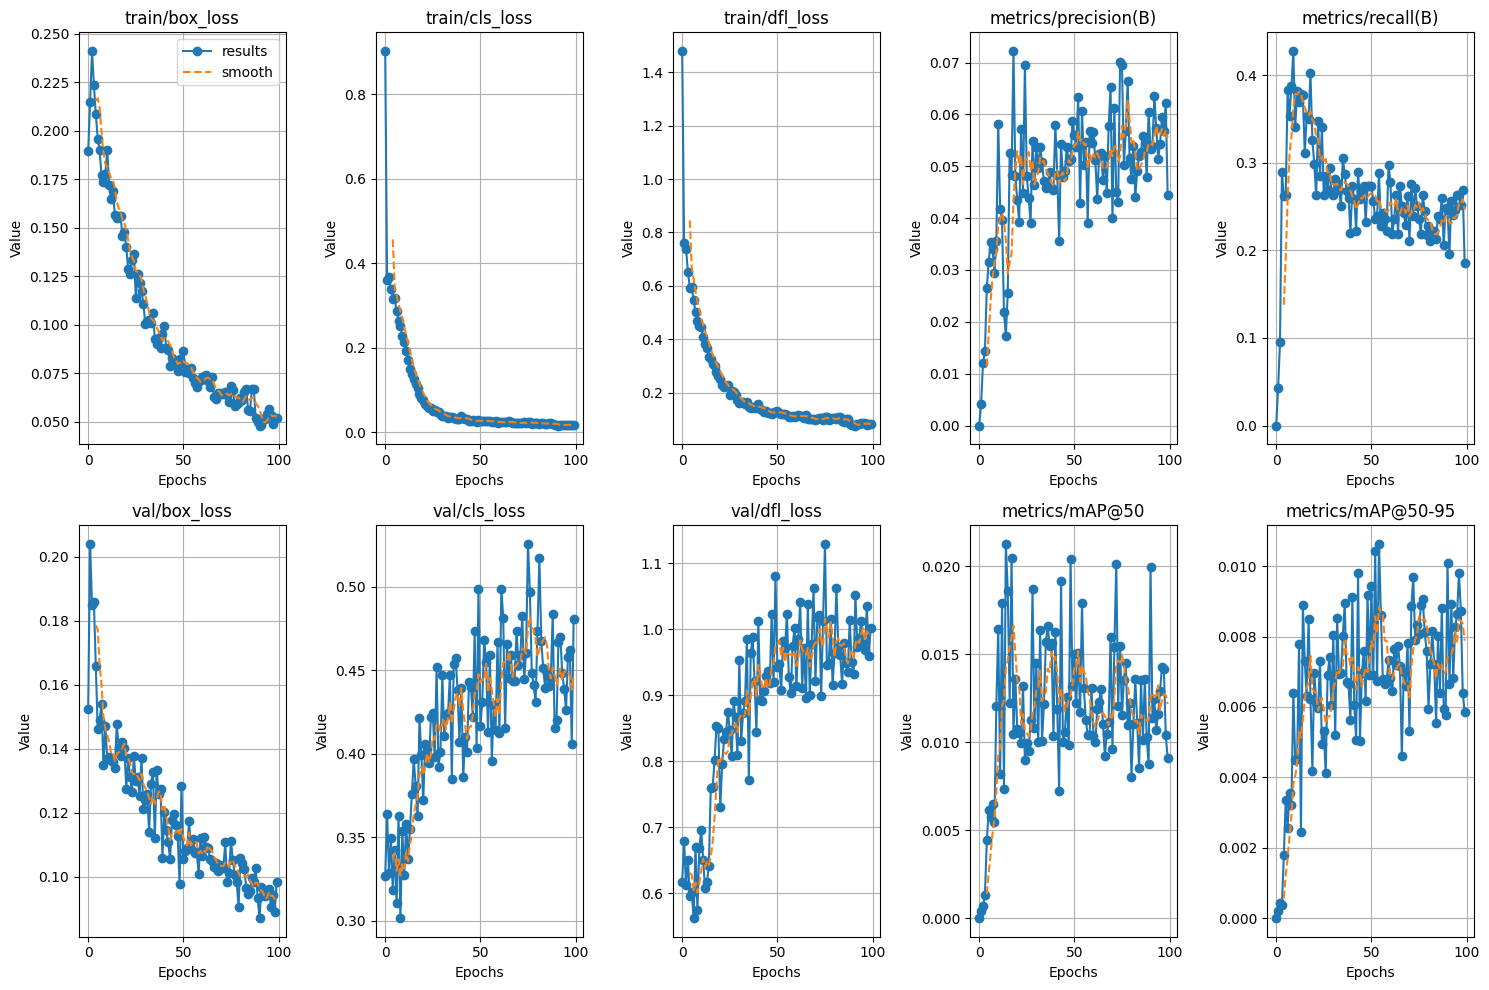

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the CSV file
file_path = '/content/training_metrics_fast_r_cnn_taco_100_epochs.csv'
df = pd.read_csv(file_path)

# List of metrics to plot
metrics = [
    'train/box_loss', 'train/cls_loss', 'train/dfl_loss',
    'metrics/precision(B)', 'metrics/recall(B)',
    'val/box_loss', 'val/cls_loss', 'val/dfl_loss',
    'metrics/mAP@50', 'metrics/mAP@50-95'
]

# Create a grid layout for the plots
plt.figure(figsize=(15, 10))

# Loop through metrics and assign positions
for idx, metric in enumerate(metrics):
    plt.subplot(2, 5, idx + 1)  # 2 rows, 5 columns grid
    if metric in df.columns:
        plt.plot(df[metric], label='results', marker='o')
        plt.plot(df[metric].rolling(window=5).mean(), label='smooth', linestyle='--')
    else:
        plt.text(0.5, 0.5, f"{metric} not found", ha='center', va='center')

    plt.title(metric)
    plt.xlabel('Epochs')
    plt.ylabel('Value')
    plt.grid(True)
    if idx == 0:
        plt.legend()

plt.tight_layout()
plt.show()

